In [25]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [26]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [27]:
# X is the data and y is the labels

X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


(28, 28)


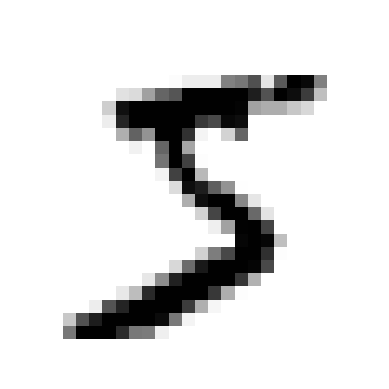

5


In [43]:
# Taking a look at one digit from the dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# getting the values of the first row as an array
some_digit = X.iloc[0].values

some_digit_image = some_digit.reshape(28, 28)
print(some_digit_image.shape)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# looks like a 5, let's check the label
print(y[0]) # 5

# transforming y to integers
y = y.astype(np.uint8)

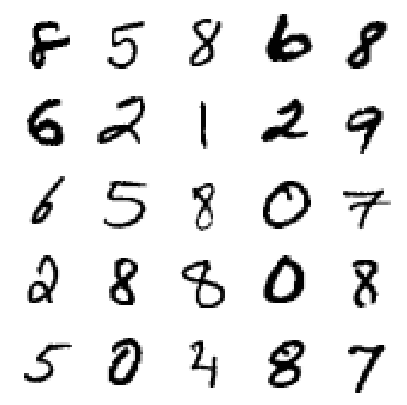

In [54]:
# Looking at more digits

random_records = X.sample(n=25).values

# Reshape the first 20 rows into a 28x28x20 tensor
images_tensor = random_records.reshape(25, 28, 28)

# Plot the images in a grid
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_tensor[i], cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis('off')
plt.show()


In [55]:
#****************************************************
# Splitting the data into training and test sets
#****************************************************

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [60]:
# Identifying "number 5"
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#****************************************************

# Training a Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Using it to detect images of the number 5
print(sgd_clf.predict([some_digit])) # True

#****************************************************

[ True]


c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [65]:
# Performance measures
# Using cross-validation (it can also be used cross_val_score() function)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index].values
    y_train_folds = y_train_5.iloc[train_index].values
    X_test_fold = X_train.iloc[test_index].values
    y_test_fold = y_train_5.iloc[test_index].values
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints around 0.96
    
# Now we try it using the installed function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # same results

0.95035
0.96035
0.9604


array([0.95035, 0.96035, 0.9604 ])

In [66]:
# Creating a "dumb" not-5 classifier. Gets 91% accuracy just because only 10% of digits are 5's
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") # around 0.91

# This shows that accuracy is generally not the preferred performance measure
# Especially when dealing with skewed datasets (i.e. when some classes are much more frequent than others)

array([0.91125, 0.90855, 0.90915])

[[53892   687]
 [ 1891  3530]]
0.8370879772350012
0.6511713705958311
0.7325171197343847


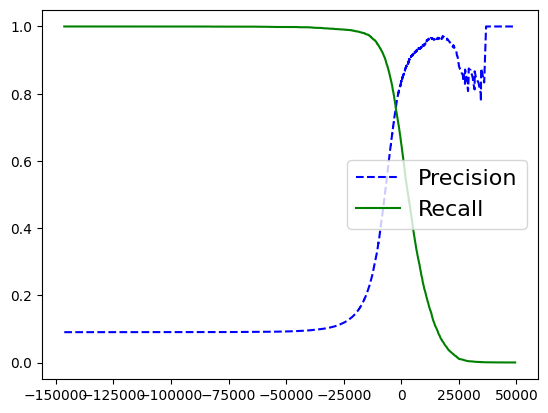

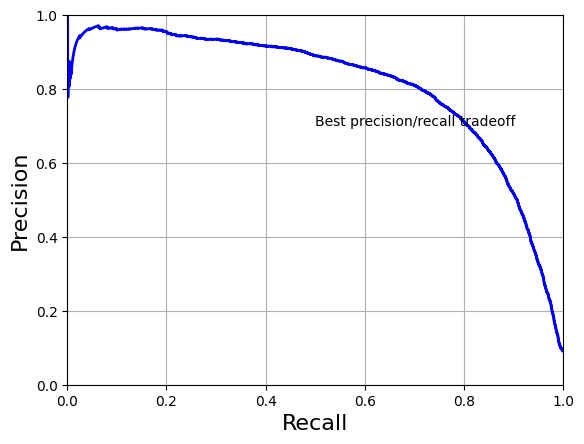

In [79]:
#****************************************************
# Confusion matrix
#****************************************************
# A better way to evaluate the performance of a classifier is to use the confusion matrix
# The general idea is to count the number of times instances of class A are classified as class B

from sklearn.model_selection import cross_val_predict # same as the other but returns the predictions instead of the evaluation scores

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

# Each row in a confusion matrix represents an actual class, while each column represents a predicted class
# The first row of this matrix considers non-5 images (the negative class): 53,272 were correctly classified as non-5's (true negatives)
# while the remaining 1,307 were wrongly classified as 5's (false positives)
# The second row considers the images of 5's (the positive class): 1,077 were wrongly classified as non-5's (false negatives)
# while the remaining 4,344 were correctly classified as 5's (true positives)

# A perfect classifier would get a confussion matrix with only numbers on the main diagonal


#****************************************************
# Precision and Recall
#****************************************************
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # Claims an image is 5. 83% of times is correct
print(recall_score(y_train_5, y_train_pred)) # Detects 65% of the 5's

# F1 score is the harmonic mean of precision and recall
# It gives more weight to low values
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred)) # 73%

# Which one (precision or recall) to use depends on the problem at hand
# Precision/Recall tradeoff: increasing precision reduces recall and viceversa
# The threshold can be changed to get the desired precision/recall

# How to chose a threshold?
# We will plot precision and recall for all possible thresholds
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="lower right", fontsize=16)
    # we can highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# It can also be done by plotting precision vs recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()


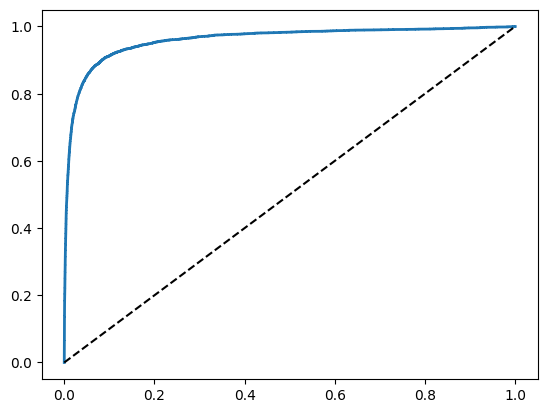

0.9604938554008616


In [81]:
# The ROC curve
# Receiver Operating Characteristic curve
# It plots the True Positive Rate (recall) against the False Positive Rate (FPR)
# FPR = 1 - True Negative Rate (TNR) = 1 - Specificity
# TNR = Specificity
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    # We can add axis labels and grid
    
plot_roc_curve(fpr, tpr)
plt.show()

# The higher the recall (TPR), the more false positives (FPR) the classifier produces
# The dotted line represents the ROC curve of a purely random classifier
# A good classifier stays as far away from that line as possible (towards the top-left corner)

# One way to compare classifiers is to measure the area under the curve (AUC). We aim for 1. A random classifier has 0.5.
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores)) # 0.96



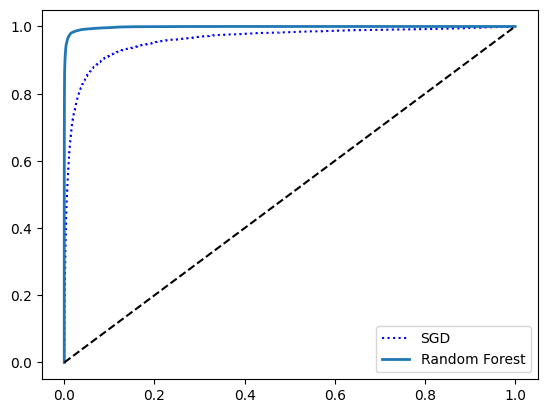

0.9983436731328145

In [87]:
#****************************************************
# Random Forest Classifier
#****************************************************
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# We create an array of probability that the given instance belongs to the given class
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# In order to plot the ROC curve, we need scores, not probabilities
# We can use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# And we plot the ROC curve together with the previous one (to compare)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# The Random Forest classifier is superior to the SGD classifier because its ROC curve is closer to the top-left corner
roc_auc_score(y_train_5, y_scores_forest) # 0.99
# The ROC AUC score confirms that

# We can find the precision and recall. It will give 99% and 86.6% respectively



In [93]:
#****************************************************
# Multiclass classification (detecting more than 5's)
#****************************************************
# Some algorithms are capable of handling multiple classes directly
# Others are strictly binary classifiers
# However, there are strategies to perform multiclass classification using multiple binary classifiers

# One-versus-all (OvA) strategy (train several binary classifiers and take the one with the highest score)

# Another strategy is to train a binary classifier for every pair of digits (0's vs 1's and so on) (FASTER TO TRAIN)

# Scikit-learn detects when using multi-class classification task and applies OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

# Checking "under the hood" the scores of each classifier
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
np.argmax(some_digit_scores)
sgd_clf.classes_


[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [95]:
# Training a Random Forest Classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

# Scikit-learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes

forest_clf.predict_proba([some_digit])
# Probabilities that the Random Forest Classifier gives to each class:
# 0: 0%, 1: 0%, 2: 1%, 3: 8%, 4: 0%, 5: 90%, 6: 0%, 7: 0%, 8: 0%, 9: 1%


c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [97]:
# Evaluating the classifiers
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # around 86%

# Scaling the inputs (improves accuracy)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # around 90%


array([0.8983, 0.891 , 0.9018])

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


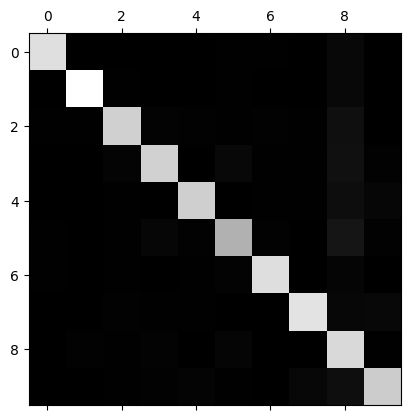

In [98]:
#****************************************************
# Error Analysis
#****************************************************
# Let's assume we have found a promising model and we want to improve it
# One way to do it is to analyze the types of errors it makes

# We can make predictions using cross_val_predict() and then call confusion_matrix()
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

# We can plot the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# The diagonal is white (most of the images are recognized)
# The 5's are a bit darker (fewer 5's are recognized)

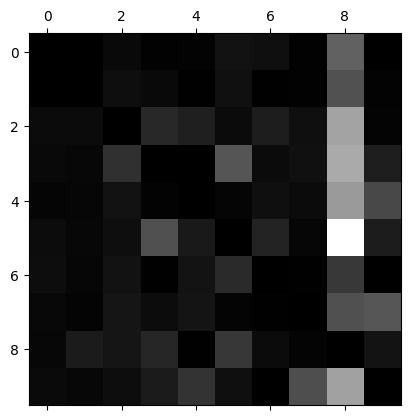

In [99]:
# Let's focus on the errors
# We need to divide the number on each cell by the number of images in the corresponding class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Let's fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Clearly seen kind of errors
# Remember that rows represent actual classes, while columns represent predicted classes
# Columns for classes 8 and 9 are quite bright, which tells us that many images get misclassified as 8's or 9's
# Rows for classes 8 and 9 are not that bad, which tells us that actual 8's and 9's are correctly classified as 8's and 9's

# Efforts should be put into reducing the false 8's and 9's (such as gathering more training data for these digits)
# Or engineering new features that would help the classifier (such as writing an algorithm to count the number of closed loops)



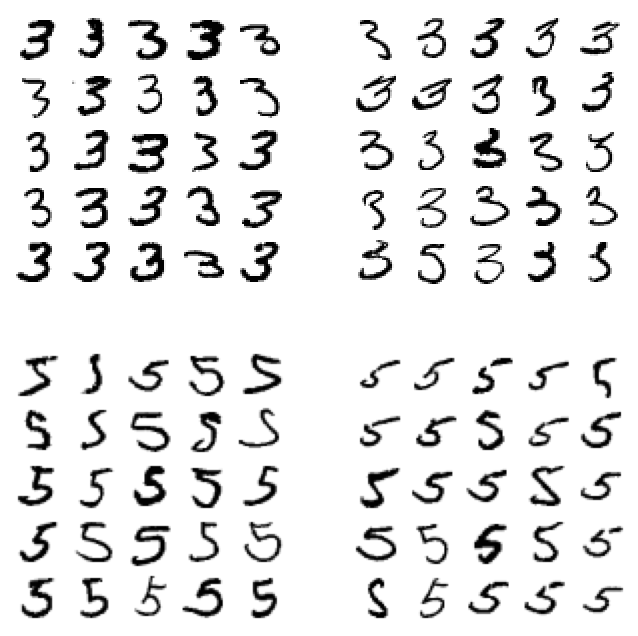

In [103]:
# Analyzing individual errors
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)].values
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)].values
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)].values
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)].values


# define plot_digits function
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# The two 5x5 blocks on the left show digits classified as 3's, while the two 5x5 blocks on the right show digits classified as 5's
# Some of the digits are so badly written that even a human would have trouble classifying them

# The classifier is a linear model, so all it does is assign a weight per class to each pixel
# When it sees a new image, it sums up the weighted pixel intensities to get a score for each class
# The class with the highest score is the one the classifier assigns
# The 3/5 confusion is likely due to the fact that the model uses a linear decision boundary

# One way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated
#****************************************************

In [106]:
#****************************************************
# Multilabel classification
#****************************************************
# Until now, each instance has always been assigned to just one class
# In some cases, we may want our classifier to output multiple classes for each instance
# Such a classification system that outputs multiple binary labels is called a multilabel classification system

# Let's create a multilabel classifier that outputs two labels: whether or not the digit is large (7, 8, or 9) and whether or not it is odd
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Prediction (with 2 outputs)
knn_clf.predict([some_digit])   # False, True which is true (The digit 5 is indeed not large (False) and odd (True))

# There are many ways to evaluate a multilabel classifier
# Selecting the right metric depends on the project

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")   # 0.976

# This assumes that all labels are equally important, which may not be the case



c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9764102655606048

c:\Users\fgrijalba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


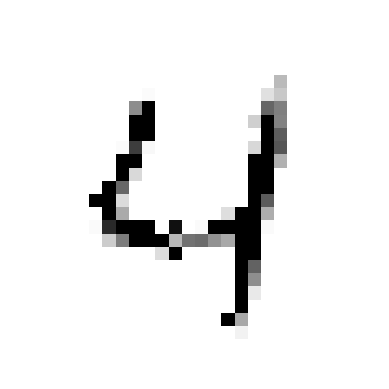

In [123]:
# Multioutput multiclass classification
# Creating a system that removes noise from images

# We start by creating the training and test sets by adding noise to the pixel intensities
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

# Training the classifier and making it clean the image
#knn_clf.fit(X_train_mod, y_train_mod)
some_index = 4
clean_digit = knn_clf.predict([X_test_mod.values[some_index]])

# Plotting the clean digit
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

plot_digit(clean_digit)

#****************************************************